In [3]:
!pip install lime


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
import cv2
import shap
import lime
from lime import lime_image
import shap
from lime import lime_image
from skimage.segmentation import mark_boundaries
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

2025-05-04 03:21:46.058655: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-04 03:21:46.195070: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746318106.273680   26692 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746318106.296679   26692 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-04 03:21:46.423036: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [5]:
# Load OASIS dataset (replace with your actual loading mechanism)
# Using the Kaggle OASIS dataset you referenced
import kagglehub
path = kagglehub.dataset_download("ninadaithal/imagesoasis")
print("Path to dataset files:", path)

Path to dataset files: /home/helal/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1
Path to dataset files: /home/helal/.cache/kagglehub/datasets/ninadaithal/imagesoasis/versions/1


In [6]:
## 1. Data Preparation with Medical Rationale
class MRIPreprocessor:
    """
    Medical Imaging Preprocessing Pipeline
    Key steps chosen for clinical relevance:
    1. Hippocampus-focused cropping (AD biomarker)
    2. Intensity normalization (scanner variability correction)
    3. Skull stripping (remove non-brain tissue)
    """
    def __init__(self, target_size=(128, 128)):
        self.target_size = target_size

    def crop_hippocampus(self, img):
        """Focus on medial temporal lobe region"""
        # Simplified - in practice would use anatomical landmarks
        h, w = img.shape
        return img[h//3:2*h//3, w//3:2*w//3]  # Center crop

    def preprocess(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = self.crop_hippocampus(img)
        img = cv2.resize(img, self.target_size)
        img = (img - np.min(img)) / (np.max(img) - np.min(img))  # Normalize
        img = np.expand_dims(img, axis=-1)  # Add channel dimension
        return img

In [7]:
# Initialize preprocessor
preprocessor = MRIPreprocessor()

In [8]:
def build_interpretable_cnn(input_shape=(128, 128, 1), num_classes=4):
    """
    CNN Architecture with interpretability features for multiclass classification:
    - 3 Convolutional layers for hierarchical feature learning
    - MaxPooling for spatial hierarchy (anatomical scale invariance)
    - Dropout for robustness (prevents overfitting to scanner artifacts)

    Args:
        input_shape: Shape of input images (height, width, channels)
        num_classes: Number of output classes (4 for your dataset)
    """
    model = Sequential([
        # Layer 1: Edge/Texture Detection
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape,
               name='edge_detection'),
        MaxPooling2D((2, 2), name='spatial_downsample_1'),

        # Layer 2: Structural Pattern Recognition
        Conv2D(64, (3, 3), activation='relu',
               name='structural_features'),
        MaxPooling2D((2, 2), name='spatial_downsample_2'),

        # Layer 3: High-level Feature Integration
        Conv2D(128, (3, 3), activation='relu',
               name='hippocampal_integration'),
        MaxPooling2D((2, 2), name='spatial_downsample_3'),

        Flatten(),
        Dropout(0.5, name='regularization'),
        Dense(128, activation='relu', name='clinical_correlates'),
        Dense(num_classes, activation='softmax', name='diagnosis_output')  # Changed to num_classes
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [9]:
# Build and visualize model
model = build_interpretable_cnn()
plot_model(model, to_file='model_architecture.png', show_shapes=True)

/home/helal/tf-gpu/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1746318114.280770   26692 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1930 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


You must install pydot (`pip install pydot`) for `plot_model` to work.


In [10]:
## 3. Training with Validation (Medical Focus)
# Create data generators with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,       # Account for head positioning variability
    width_shift_range=0.1,   # Robustness to scanning differences
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,    # Symmetry consideration
    validation_split=0.2)

# Load and preprocess data
train_generator = train_datagen.flow_from_directory(
    os.path.join(path, "Data"),
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    color_mode='grayscale')

# Add this clean validation datagen (no augmentations!)
eval_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Use it for your validation (evaluation) generator
val_generator = eval_datagen.flow_from_directory(
    os.path.join(path, "Data"),
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    color_mode='grayscale',
    shuffle=False  # Important: preserve label order
)


Found 69151 images belonging to 4 classes.
Found 17286 images belonging to 4 classes.


In [11]:
model = build_interpretable_cnn(num_classes=4)

In [12]:
# Train with callbacks for medical monitoring
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
    ])

/home/helal/tf-gpu/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


I0000 00:00:1746318129.282815   26787 service.cc:148] XLA service 0x7f5530018620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746318129.283183   26787 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Laptop GPU, Compute Capability 8.6
2025-05-04 03:22:09.337861: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746318129.682761   26787 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-04 03:22:13.744284: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng20{k2=2,k4=0,k5=0,k6=0,k7=0,k19=0} for conv (f32[32,32,126,126]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,128,128]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"act

   1/2161 ━━━━━━━━━━━━━━━━━━━━ 8:44:30 15s/step - accuracy: 0.3750 - loss: 7.3905

I0000 00:00:1746318139.442157   26787 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 144/2161 ━━━━━━━━━━━━━━━━━━━━ 3:43 111ms/step - accuracy: 0.7413 - loss: 9.0493

2025-05-04 03:22:39.300851: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[31,32,63,63]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,64,61,61]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-05-04 03:22:39.716099: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.420632184s
Trying algorithm eng0{} for conv (f32[31,32,63,63]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,64,61,61]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result

2161/2161 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.7748 - loss: 1.5421

2161/2161 ━━━━━━━━━━━━━━━━━━━━ 307s 135ms/step - accuracy: 0.7748 - loss: 1.5418 - val_accuracy: 0.7777 - val_loss: 0.8357
Epoch 2/5
Epoch 2/5
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 232s 108ms/step - accuracy: 0.7810 - loss: 0.5345 - val_accuracy: 0.7261 - val_loss: 1.0432
Epoch 3/5
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 195s 90ms/step - accuracy: 0.7843 - loss: 0.5206 - val_accuracy: 0.1588 - val_loss: 2.1621
Epoch 4/5
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 197s 91ms/step - accuracy: 0.7864 - loss: 0.5124 - val_accuracy: 0.1588 - val_loss: 2.6083
Epoch 5/5
2161/2161 ━━━━━━━━━━━━━━━━━━━━ 197s 91ms/step - accuracy: 0.7914 - loss: 0.4989 - val_accuracy: 0.1588 - val_loss: 2.5602


In [16]:
def generate_shap_explanation(model, sample_image, train_generator, num_samples=50):
    """
    Generate SHAP explanation for a single image using generator background.

    Args:
        model: Trained Keras model.
        sample_image: Single image array, shape (H, W, 1).
        train_generator: Keras generator to sample background images.
        num_samples: Number of background samples.
    """
    # Expand dims for single sample
    sample_image = np.expand_dims(sample_image, axis=0)  # (1, H, W, 1)

    # Collect background images from generator
    background_images = []
    while len(background_images) < num_samples:
        batch_images, _ = next(train_generator)
        background_images.extend(batch_images)
        if len(background_images) >= num_samples:
            break
    background_images = np.array(background_images[:num_samples])  # (num_samples, H, W, 1)

    # Initialize SHAP explainer
    explainer = shap.DeepExplainer(model, background_images)

    # Compute SHAP values
    shap_values = explainer.shap_values(sample_image)

    # Plot SHAP explanation
    shap.image_plot(shap_values, -sample_image, show=True)


In [17]:
def generate_lime_explanation(model, sample_image, class_names, axis=None):
    from lime import lime_image
    from skimage.segmentation import mark_boundaries

    explainer = lime_image.LimeImageExplainer()

    def predict_fn(images):
        images = images.astype(np.float32)
        images = images / 255.0 if images.max() > 1 else images
        if images.ndim == 3:
            images = np.expand_dims(images, -1)
        elif images.ndim == 4 and images.shape[-1] != 1:
            images = np.expand_dims(images[..., 0], -1)
        return model.predict(images)

    explanation = explainer.explain_instance(
        image=sample_image.squeeze(),
        classifier_fn=predict_fn,
        top_labels=len(class_names),
        hide_color=None,
        num_samples=1000
    )

    top_label = explanation.top_labels[0]
    temp, mask = explanation.get_image_and_mask(
        top_label,
        positive_only=True,
        num_features=10,
        hide_rest=False
    )

    lime_img = mark_boundaries(temp, mask, color=(1, 1, 0))

    if axis is not None:
        axis.imshow(lime_img)
        axis.set_title(f"LIME Explanation: {class_names[top_label]}")
        axis.axis('off')
    else:
        plt.figure(figsize=(6, 6))
        plt.imshow(lime_img)
        plt.title(f"LIME Explanation: {class_names[top_label]}")
        plt.axis('off')
        plt.show()


  0%|                                                                                  | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


  1%|▋                                                                        | 10/1000 [00:02<04:36,  3.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  2%|█▍                                                                       | 20/1000 [00:02<01:59,  8.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


  3%|██▏                                                                      | 30/1000 [00:03<01:09, 13.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


  4%|██▉                                                                      | 40/1000 [00:03<00:47, 20.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  5%|███▋                                                                     | 50/1000 [00:03<00:34, 27.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|████▍                                                                    | 60/1000 [00:03<00:25, 36.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  7%|█████                                                                    | 70/1000 [00:03<00:21, 43.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  8%|█████▊                                                                   | 80/1000 [00:03<00:17, 51.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  9%|██████▌                                                                  | 90/1000 [00:03<00:15, 60.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 738ms/step


 10%|███████▏                                                                | 100/1000 [00:04<00:33, 27.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 11%|███████▉                                                                | 110/1000 [00:04<00:25, 34.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 12%|████████▋                                                               | 120/1000 [00:04<00:21, 40.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 13%|█████████▎                                                              | 130/1000 [00:04<00:18, 48.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 14%|██████████                                                              | 140/1000 [00:05<00:15, 55.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 15%|██████████▊                                                             | 150/1000 [00:05<00:13, 63.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 16%|███████████▌                                                            | 160/1000 [00:05<00:11, 70.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 17%|████████████▏                                                           | 170/1000 [00:05<00:10, 75.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 18%|████████████▉                                                           | 180/1000 [00:05<00:11, 72.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 19%|█████████████▋                                                          | 190/1000 [00:06<00:40, 20.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 20%|██████████████▍                                                         | 200/1000 [00:06<00:30, 26.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 21%|███████████████                                                         | 210/1000 [00:07<00:23, 33.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 22%|███████████████▊                                                        | 220/1000 [00:07<00:18, 41.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 23%|████████████████▌                                                       | 230/1000 [00:07<00:15, 50.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 24%|█████████████████▎                                                      | 240/1000 [00:07<00:13, 58.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 25%|██████████████████▎                                                     | 254/1000 [00:07<00:09, 74.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 27%|███████████████████▍                                                    | 270/1000 [00:07<00:09, 78.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 28%|████████████████████▏                                                   | 280/1000 [00:07<00:08, 81.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 29%|████████████████████▉                                                   | 290/1000 [00:07<00:08, 86.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


 30%|█████████████████████▌                                                  | 300/1000 [00:09<00:32, 21.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 31%|██████████████████████▎                                                 | 310/1000 [00:09<00:25, 27.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 32%|███████████████████████                                                 | 320/1000 [00:09<00:20, 33.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 33%|███████████████████████▊                                                | 330/1000 [00:09<00:16, 40.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 34%|████████████████████████▍                                               | 340/1000 [00:09<00:14, 47.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 35%|█████████████████████████▏                                              | 350/1000 [00:09<00:11, 54.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 36%|█████████████████████████▉                                              | 360/1000 [00:10<00:10, 62.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 37%|██████████████████████████▋                                             | 370/1000 [00:10<00:09, 69.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 38%|███████████████████████████▎                                            | 380/1000 [00:10<00:08, 75.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 39%|████████████████████████████                                            | 390/1000 [00:10<00:07, 80.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|████████████████████████████▊                                           | 400/1000 [00:11<00:28, 20.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 41%|█████████████████████████████▌                                          | 410/1000 [00:11<00:21, 27.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 42%|██████████████████████████████▏                                         | 420/1000 [00:11<00:17, 32.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 43%|██████████████████████████████▉                                         | 430/1000 [00:12<00:14, 40.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████████████████████████████████                                        | 446/1000 [00:12<00:09, 57.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 46%|█████████████████████████████████                                       | 460/1000 [00:12<00:08, 63.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 48%|██████████████████████████████████▌                                     | 480/1000 [00:12<00:06, 76.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 50%|████████████████████████████████████                                    | 500/1000 [00:13<00:17, 28.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 51%|█████████████████████████████████████                                   | 514/1000 [00:14<00:13, 36.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 52%|█████████████████████████████████████▋                                  | 524/1000 [00:14<00:11, 41.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 53%|██████████████████████████████████████▍                                 | 533/1000 [00:14<00:10, 46.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 55%|███████████████████████████████████████▍                                | 547/1000 [00:14<00:07, 58.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|████████████████████████████████████████▏                               | 558/1000 [00:14<00:06, 67.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


 57%|████████████████████████████████████████▉                               | 569/1000 [00:14<00:06, 62.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 58%|█████████████████████████████████████████▌                              | 578/1000 [00:14<00:06, 66.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 59%|██████████████████████████████████████████▍                             | 590/1000 [00:16<00:19, 21.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|███████████████████████████████████████████▏                            | 600/1000 [00:16<00:14, 26.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 61%|███████████████████████████████████████████▉                            | 610/1000 [00:16<00:11, 33.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 62%|████████████████████████████████████████████▋                           | 620/1000 [00:16<00:09, 41.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 63%|█████████████████████████████████████████████▎                          | 630/1000 [00:16<00:07, 49.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 65%|██████████████████████████████████████████████▊                         | 650/1000 [00:16<00:05, 66.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 67%|████████████████████████████████████████████████▏                       | 670/1000 [00:16<00:04, 79.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|█████████████████████████████████████████████████▏                      | 684/1000 [00:17<00:03, 90.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 70%|██████████████████████████████████████████████████▍                     | 700/1000 [00:18<00:10, 28.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 71%|███████████████████████████████████████████████████                     | 710/1000 [00:18<00:08, 33.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 72%|███████████████████████████████████████████████████▊                    | 720/1000 [00:18<00:07, 39.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 73%|████████████████████████████████████████████████████▌                   | 730/1000 [00:18<00:05, 46.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|█████████████████████████████████████████████████████▎                  | 740/1000 [00:18<00:04, 53.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 75%|██████████████████████████████████████████████████████                  | 750/1000 [00:19<00:04, 61.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 77%|███████████████████████████████████████████████████████▍                | 770/1000 [00:19<00:03, 75.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|████████████████████████████████████████████████████████▋               | 787/1000 [00:19<00:02, 93.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 80%|█████████████████████████████████████████████████████████▌              | 800/1000 [00:19<00:02, 84.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 81%|██████████████████████████████████████████████████████████▍             | 811/1000 [00:20<00:07, 26.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 82%|███████████████████████████████████████████████████████████             | 820/1000 [00:20<00:05, 30.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


 83%|███████████████████████████████████████████████████████████▊            | 830/1000 [00:21<00:04, 34.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 84%|████████████████████████████████████████████████████████████▍           | 840/1000 [00:21<00:03, 40.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 85%|█████████████████████████████████████████████████████████████▏          | 850/1000 [00:21<00:03, 48.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 86%|█████████████████████████████████████████████████████████████▉          | 860/1000 [00:21<00:02, 55.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 87%|██████████████████████████████████████████████████████████████▋         | 870/1000 [00:21<00:02, 61.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|███████████████████████████████████████████████████████████████▎        | 880/1000 [00:21<00:01, 68.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 89%|████████████████████████████████████████████████████████████████        | 890/1000 [00:21<00:01, 75.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 90%|████████████████████████████████████████████████████████████████▊       | 900/1000 [00:23<00:04, 21.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████████████████████████████████████████████████████████████▌      | 910/1000 [00:23<00:03, 27.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|██████████████████████████████████████████████████████████████████▏     | 920/1000 [00:23<00:02, 34.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 93%|██████████████████████████████████████████████████████████████████▉     | 930/1000 [00:23<00:01, 42.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 94%|███████████████████████████████████████████████████████████████████▋    | 940/1000 [00:23<00:01, 48.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 95%|████████████████████████████████████████████████████████████████████▍   | 950/1000 [00:23<00:00, 57.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 97%|█████████████████████████████████████████████████████████████████████▊  | 970/1000 [00:23<00:00, 72.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 99%|███████████████████████████████████████████████████████████████████████▏| 989/1000 [00:23<00:00, 94.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.47it/s]


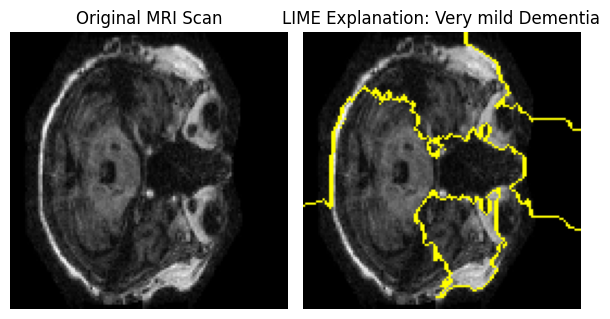

In [19]:
# Load sample image
sample_batch, _ = next(iter(val_generator))
sample_image = sample_batch[0]

# Convert to grayscale if needed
if sample_image.shape[-1] != 1:
   sample_image = sample_image[..., 0][..., np.newaxis]

# Create figure for original image
fig, axs = plt.subplots(1, 2, figsize=(6, 6))

# Original Image
axs[0].imshow(sample_image.squeeze(), cmap='gray')
axs[0].set_title('Original MRI Scan')
axs[0].axis('off')

# Use class_names from cell 13
class_names = list(val_generator.class_indices.keys())
generate_lime_explanation(model, sample_image, class_names, axis=axs[1])

plt.tight_layout()
plt.show()


In [20]:
# Get a batch from validation generator
val_images, _ = next(iter(val_generator))
sample_image = val_images[0]  # shape (128, 128, 1)

# Get class names
class_names = list(val_generator.class_indices.keys())

/home/helal/tf-gpu/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_11
Received: inputs=['Tensor(shape=(10, 128, 128, 1))']
  warnings.warn(msg)
/home/helal/tf-gpu/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_11
Received: inputs=['Tensor(shape=(20, 128, 128, 1))']
  warnings.warn(msg)


/home/helal/tf-gpu/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_11
Received: inputs=['Tensor(shape=(1, 128, 128, 1))']
  warnings.warn(msg)


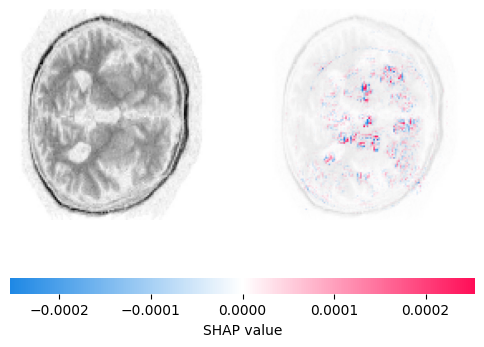

In [22]:
# Run SHAP with fewer background samples and use train_generator to avoid OOM
generate_shap_explanation(model, sample_image, train_generator, num_samples=10)

In [23]:
plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

In [24]:
def plot_confusion_matrix(model, generator):
    """Plot multiclass confusion matrix"""
    # Get true labels
    y_true = generator.classes
    class_names = list(generator.class_indices.keys())

    # Get predicted probabilities and convert to class predictions
    steps = np.ceil(generator.samples / generator.batch_size).astype(int)
    y_probs = model.predict(generator, steps=steps, verbose=1)
    y_pred = np.argmax(y_probs, axis=1)  # Get class with highest probability

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.ylabel('True Diagnosis')
    plt.xlabel('Predicted Diagnosis')
    plt.title('Clinical Confusion Matrix')
    plt.show()

541/541 ━━━━━━━━━━━━━━━━━━━━ 33s 58ms/step


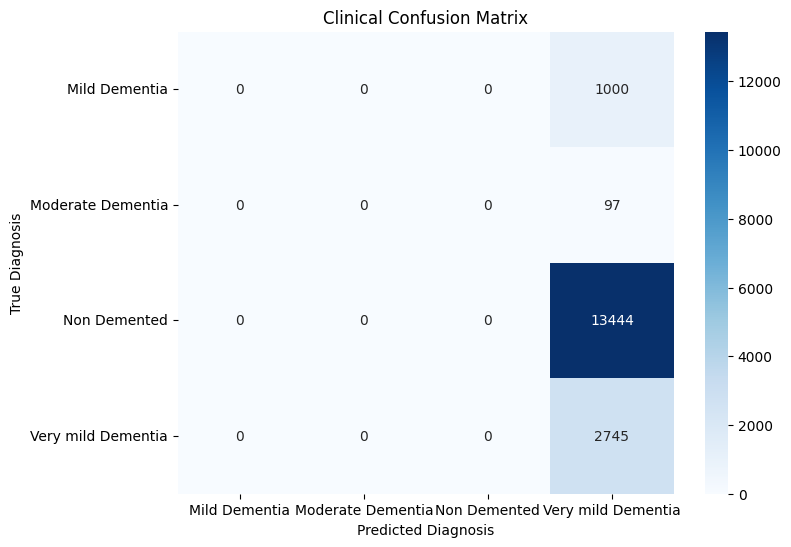

In [25]:
plot_confusion_matrix(model, val_generator)

In [26]:
from sklearn.preprocessing import label_binarize

def plot_roc_curve(model, generator):
    y_true = generator.classes
    class_names = list(generator.class_indices.keys())

    y_score = model.predict(generator)
    y_true_bin = label_binarize(y_true, classes=np.arange(len(class_names)))

    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc(fpr, tpr):.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curves')
    plt.legend()
    plt.show()

541/541 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step


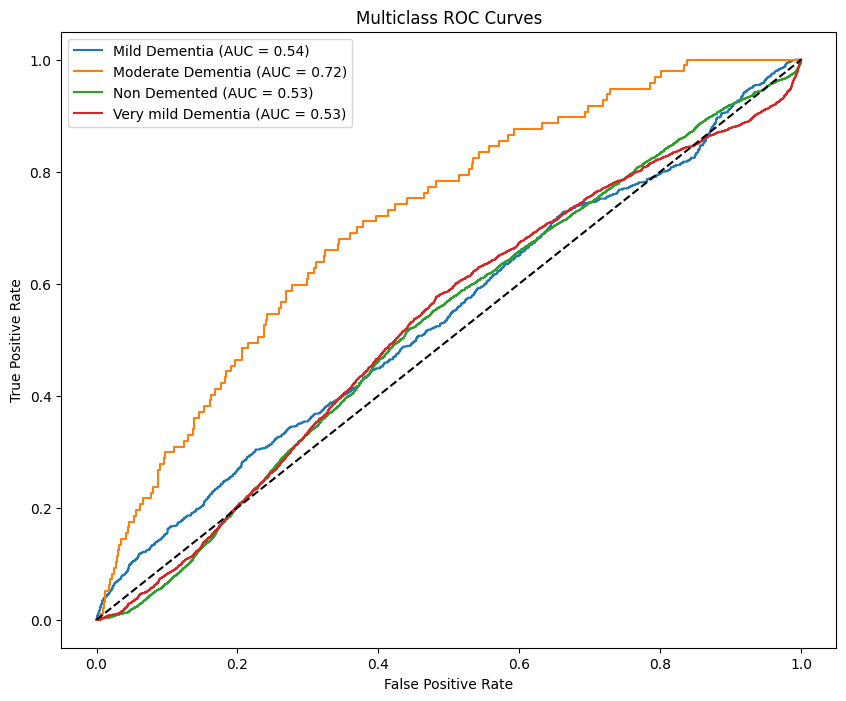

In [27]:
plot_roc_curve(model, val_generator)